#Exercise on GANs

What you're required to implement in this assignment requires both a discriminator for classifying whether a given image is real or generated and a generator model to transform an input to a full two-dimensional image of pixel values.

Completing the necessary imports:

In [ ]:
from tensorflow.keras.optimizers import Adam
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

import numpy as np
import matplotlib.pyplot as plt
import keras
from numpy.random import rand
from tensorflow.keras.utils import plot_model

Step 1: Loading the dataset

In [ ]:
from keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Running the code loads the dataset and prints the shape of the input and output components of the train and test splits of images. There are 60K examples in the training set and 10K in the test set and each image is a square of 28 by 28 pixels.

Step 2: Data Visualisation

Plotting a random sample from the MNIST dataset:

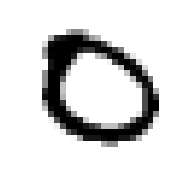

label: 0


In [ ]:
'''INSERT YOUR CODE TO PLOT A RANDOM SAMPLE FROM THE MNIST DATASET'''
np.random.seed(256)

idx = np.random.randint(low=0, high=60000)

plt.figure(figsize=(3,3))
plt.imshow(trainX[idx], cmap='gray_r');
plt.axis('off')
plt.show()
print(f'label: {trainy[idx]}')

For the purpose of visualisation alone, plotting the samples from the dataset with a light background and darker digits would be better. This can be done as shown:

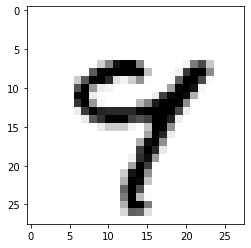

In [ ]:
pyplot.imshow(trainX[54], cmap='gray_r');

These will be the basis for training of the GAN. 

Step 3: The Discriminator Model - Definition

The purpose of the discriminator model is to define the likelihood of whether the sample is real or fake. We want to define a discriminator with 2 convolutional layers with 64 filters each, kernel size 3 and stride 2. Create this model by stacking up the required layers. Use LeakyReLU (alpha = 0.2) and Dropout (0.4). The compilation has been done for you. 

In [ ]:
def discriminator(input_shape=(28,28,1)):
    '''INSERT YOUR CODE FOR THE MODEL DEFINITION BASED ON THE DESCRIPTION GIVEN ABOVE'''
    # discriminator model
    model = keras.models.Sequential()
#     model.add(keras.layers.Rescaling(1./255, input_shape=input_shape))
#     model.add(keras.layers.Conv2D(filters=64, 
#                                   kernel_size=(3,3), 
#                                   strides=(2,2)))
    model.add(keras.layers.Conv2D(filters=64, 
                                  kernel_size=(3,3), 
                                  strides=(2,2),
                                  input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(filters=64, 
                                  kernel_size=(3,3), 
                                  strides=(2,2)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    
    #Model compilation
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = discriminator()

Print the model summary and save the model plot.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        640       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 13, 13, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 64)          0         
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 2304)             

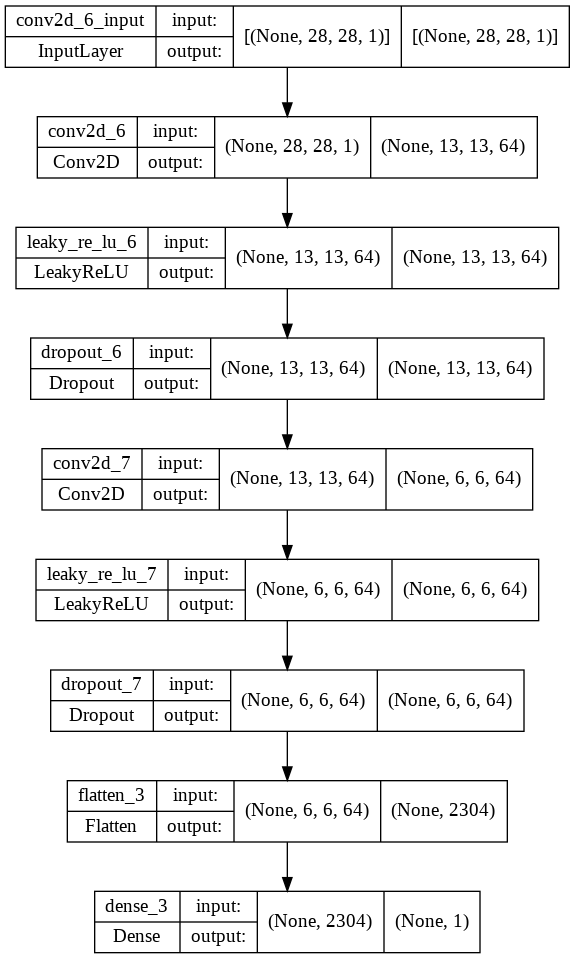

In [ ]:
model.summary()
plot_model(model, to_file='disc.png', show_shapes=True, show_layer_names=True)

We could start training this model now with real examples with a class label of one, and randomly generated samples with a class label of zero.

The development of these elements will be useful later, and it helps to see that the discriminator is just a normal neural network model for binary classification.

Step 4: The Discriminator Model - Training

In [ ]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

The generate_real_samples() function below takeS the training dataset as an argument and selectS a random subsample of images. It also returnS class labels for the sample, specifically a class label of 1, to indicate real images.

In [ ]:
def generate_real_samples(dataset, n_samples):
    #Choosing random instances
    ix = randint(0, dataset.shape[0], n_samples)
    #Retrieving Images
    X = dataset[ix]
    #Generating class labels
    y = ones((n_samples, 1))
    return X, y

For a source of fake images, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1] like our scaled real images. 

The generate_fake_samples() function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

In [ ]:
def generate_fake_samples(n_samples):
    X = rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
#Training the model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch/2)
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        if (i+1)%10 == 0:
            print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Running the following code first defines the model, loads the MNIST dataset, then trains the discriminator model.

In [ ]:
model = discriminator()
rdata = load_real_samples()

train_discriminator(model=model, dataset=rdata, n_iter=100, n_batch=256)

>10 real=64% fake=99%
>20 real=71% fake=100%
>30 real=91% fake=100%
>40 real=98% fake=100%
>50 real=99% fake=100%
>60 real=100% fake=100%
>70 real=100% fake=100%
>80 real=100% fake=100%
>90 real=100% fake=100%
>100 real=100% fake=100%


Now that we have defined and trained the discriminator model, we need to look at developing the generator model.

Step 6: The Generator Model - Definition

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values. The model has been defined for you.

In [ ]:
def generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

latent_dim = 100
model = generator(latent_dim)

Why do you think '128' has been used? Answer below:

Here, we're using a relatively large number (128) because we want our network to try different combinations with the input and create multiple versions of it. These can be collapsed into a single and final image at the end of the network.

Print the model summary and save the model plot.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

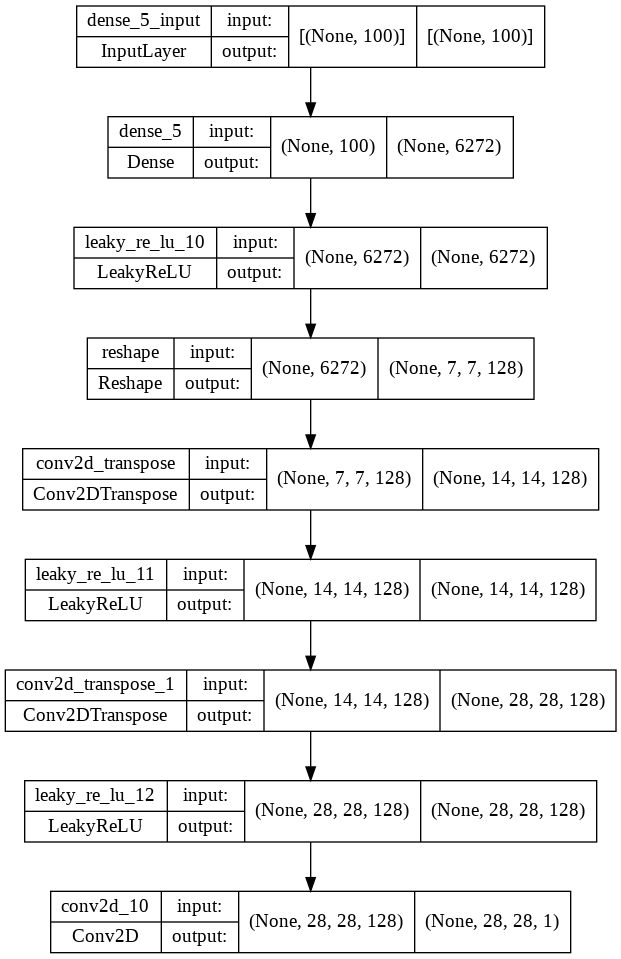

In [ ]:
model.summary()
plot_model(model, to_file='gen.png', show_shapes=True, show_layer_names=True)

The first hidden layer has 6,272 parameters or 128 * 7 * 7, the activations of which are reshaped into 128 7×7 feature maps. The feature maps are then upscaled via the two Conv2DTranspose layers to the desired output shape of 28×28, until the output layer, where a single activation map is output.

Write the function generate_latent_points() to generate random points in the latent space. You may use the rand() and reshape() function.

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    '''INSERT YOUR CODE FOR GENERATING LATENT POINTS'''
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# use the generator to generate n fake examples with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    #Predicting outputs
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

Running the following code will generate 25 examples of fake MNIST images and visualize them on a single plot of 5 by 5 images.

In [ ]:
latent_dim = 100
model = generator(latent_dim)
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

Write the code to visualise the 25 generated samples as a 5x5 plot

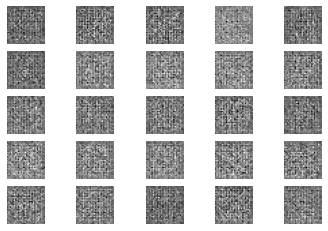

In [ ]:
fig, ax = plt.subplots(5,5)
ax = np.ravel(ax)

for i in range(n_samples):
    '''INSERT YOUR CODE TO VISUALISE SAMPLES'''
    ax[i].imshow(X[i,:,:,0], cmap='gray_r');
    ax[i].axis('off')

ax = np.reshape(ax, (5,5))
plt.show();

Step 7: The Generator Model - Training

A new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    '''INSERT YOUR CODE TO ADD LAYERS TO THE GAN'''
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_7 (Sequential)   (None, 1)                 39873     
                                                                 
Total params: 1,204,162
Trainable params: 1,164,289
Non-trainable params: 39,873
_________________________________________________________________


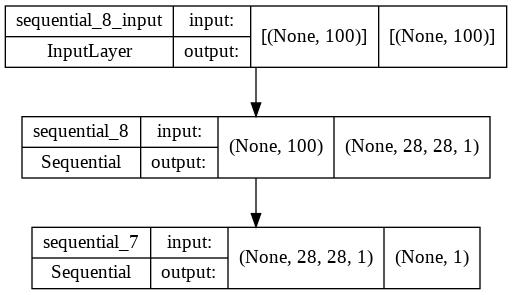

In [ ]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Running the code first creates a summary of the composite model.

The model expects MNIST images as input and predict a single value as output.

STEP 8: Training the GAN

Only the generator will be updated each epoch, leaving the discriminator with default model weights.

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

Step 9: Evaluating Model Performance

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79, 152/234, d=0.693, g=0.711
>79, 153/234, d=0.692, g=0.692
>79, 154/234, d=0.691, g=0.683
>79, 155/234, d=0.688, g=0.689
>79, 156/234, d=0.699, g=0.702
>79, 157/234, d=0.691, g=0.703
>79, 158/234, d=0.691, g=0.710
>79, 159/234, d=0.695, g=0.698
>79, 160/234, d=0.691, g=0.681
>79, 161/234, d=0.685, g=0.691
>79, 162/234, d=0.692, g=0.707
>79, 163/234, d=0.695, g=0.717
>79, 164/234, d=0.691, g=0.707
>79, 165/234, d=0.698, g=0.696
>79, 166/234, d=0.693, g=0.686
>79, 167/234, d=0.692, g=0.679
>79, 168/234, d=0.692, g=0.679
>79, 169/234, d=0.693, g=0.680
>79, 170/234, d=0.687, g=0.695
>79, 171/234, d=0.689, g=0.703
>79, 172/234, d=0.696, g=0.701
>79, 173/234, d=0.690, g=0.714
>79, 174/234, d=0.695, g=0.724
>79, 175/234, d=0.695, g=0.711
>79, 176/234, d=0.689, g=0.688
>79, 177/234, d=0.688, g=0.690
>79, 178/234, d=0.693, g=0.702
>79, 179/234, d=0.691, g=0.706
>79, 180/234, d=0.697, g=0.696
>79, 181/234, d=0.688, g=0.694
>79, 182/234, d=0.6

In [ ]:
(_, _), (testX, _) = load_data()
testX = expand_dims(testX, axis=-1)
testX = testX.astype('float32')
testX = testX / 255.0

summarize_performance(100, g_model=g_model, d_model=d_model, dataset=testX, latent_dim=100, n_samples=100)

>Accuracy real: 42%, fake: 67%


In [ ]:
summarize_performance(100, g_model, d_model, dataset, latent_dim, n_samples=100)

>Accuracy real: 40%, fake: 70%


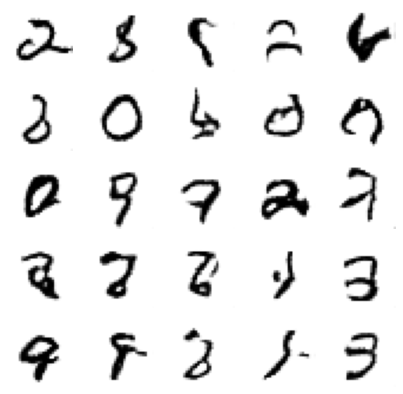

In [ ]:
new_latent_points = generate_latent_points(100, 25)
pred = g_model.predict(new_latent_points)

fig, ax = plt.subplots(5,5)
fig.set_size_inches(7, 7)
ax = np.ravel(ax)

for i in range(n_samples):
    ax[i].imshow(pred[i,:,:,0], cmap='gray_r');
    ax[i].axis('off')

ax = np.reshape(ax, (5,5))
plt.show();